In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
from pathlib import Path
import time
# import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d.io import get_tif_tag
from suite3d.io import tiff_utils as tfu
from suite3d import file_utils as flu
import colorcet
from suite3d import plot_utils as plot

No skimage
Missing some packages
Install gitpython for dev benchmarking to work
NO MRCFILE
Issues importing compute components
No Napari
No PyQtGraph
No MRCFile


In [3]:
fig_dir = Path('/mnt/md0/s3d-figures')
figname = 'fig5'
fdir = fig_dir / figname
plt.rcParams['svg.fonttype'] = 'none'
os.makedirs(fdir, exist_ok=True)

In [4]:
exp_str = 'SS003_2024-08-06_1-2-3-4subset'
# exp_str = "SS003_2024-08-06_1-2-3-4-5-6"
job = Job('/mnt/md0/runs',exp_str, create=False)

   Found and loaded params from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/params.npy


In [5]:
corr_map_s3d = job.load_corr_map_results()['vmap']

In [7]:
seg = job.load_segmentation_results()# (output_dir_name='rois-binned-rois')
peaks = n.array([stat['peak_val'] for stat in seg['stats']])

      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/info.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-SS003_2024-08-06_1-2-3-4subset/rois/iscell.npy


In [8]:
import imreg_dft

In [9]:

save_path =  Path('/mnt/md0/runs/s2p-SS003_2024-08-06_1-2-3-4/')
all_ops = []
all_stats = []
Fs = []
spks = []
iscell = []
for plane in n.arange(7):
    planedir = (save_path / 'suite2p' / f'plane{plane}')
    statx = planedir / 'stat.npy'
    opx = planedir / 'ops.npy'
    Fsx = planedir / 'F.npy'
    spksx = planedir / 'spks.npy'
    iscellx = planedir / 'iscell.npy'
    
    all_stats.append(n.load(statx, allow_pickle=True))
    all_ops.append(n.load(opx, allow_pickle=True).item())
    Fs.append(n.load(Fsx))
    spks.append(n.load(spksx))
    iscell.append(n.load(iscellx))

iscell = n.concatenate(iscell)

mean_img = n.stack([op['meanImg'] for op in all_ops])

ref_img = n.stack([op['refImg'] for op in all_ops])

nz = mean_img.shape[0]
Fs = n.concatenate(Fs)#[iscell[:,0].astype(bool)]
spks = n.concatenate(spks)#[iscell[:,0].astype(bool)]
vmap = n.array([op['Vcorr'] for op in all_ops])

# correct plane shifts
tvecs = [[0,0]]
for i in range(len(vmap) - 1):
    tvecs.append(imreg_dft.translation(vmap[i], vmap[i+1])['tvec'])
    tvecs[-1] = tvecs[-1] + tvecs[-2]

tvecs_int = n.round(tvecs).astype(int)
vmap_3d = vmap.copy()
for i in range(vmap.shape[0]):
    vmap_3d[i] = n.roll(vmap_3d[i], tvecs_int[i], axis=(0,1))

vmap_3d_s2p = vmap_3d.copy()
stats_3d = []
overall_idx = 0
for zidx, plane_stats in enumerate(all_stats):
    for stat in plane_stats:
        if iscell[overall_idx,1]  > -1:
            stat['coords'] = (n.ones_like(stat['xpix']) * zidx, stat['ypix'] -3 +tvecs_int[zidx,0] , stat['xpix']-3 +tvecs_int[zidx,1])
            stats_3d += [stat]
        overall_idx += 1
mrs = n.array([s['mrs0'] for s in stats_3d])
coords = [stat["coords"] for stat in stats_3d]
filt = mrs > 0.9

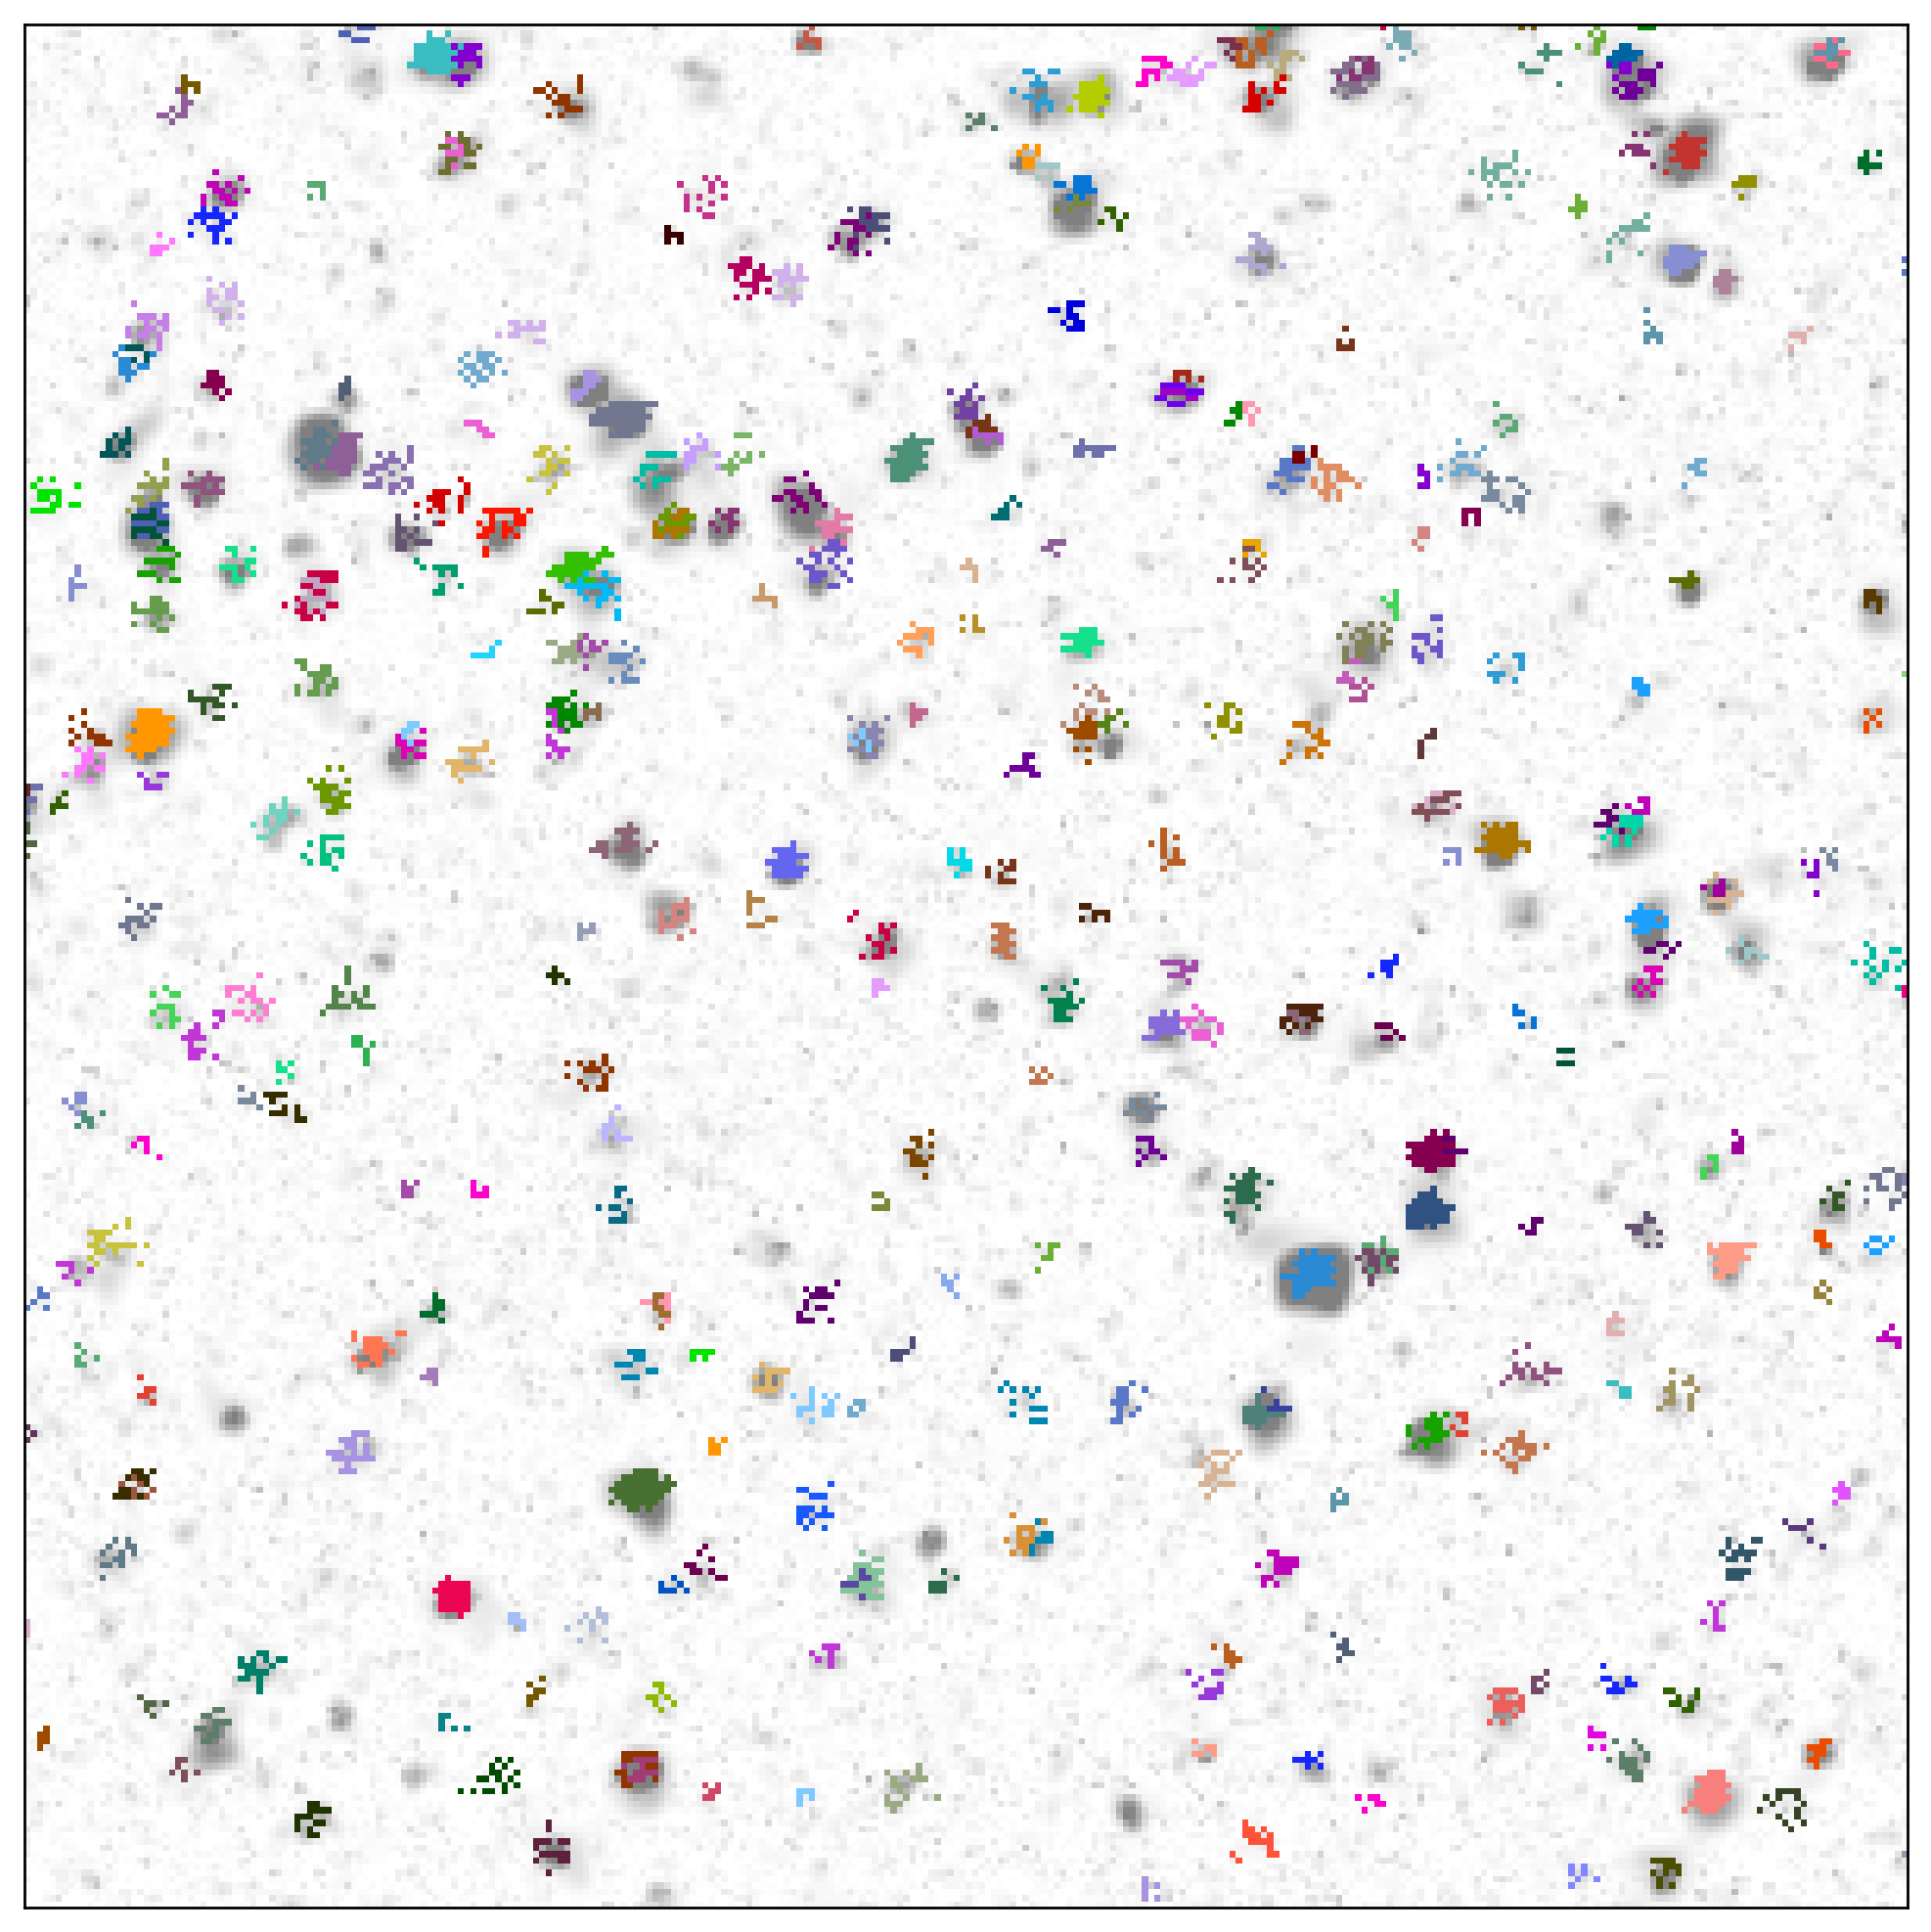

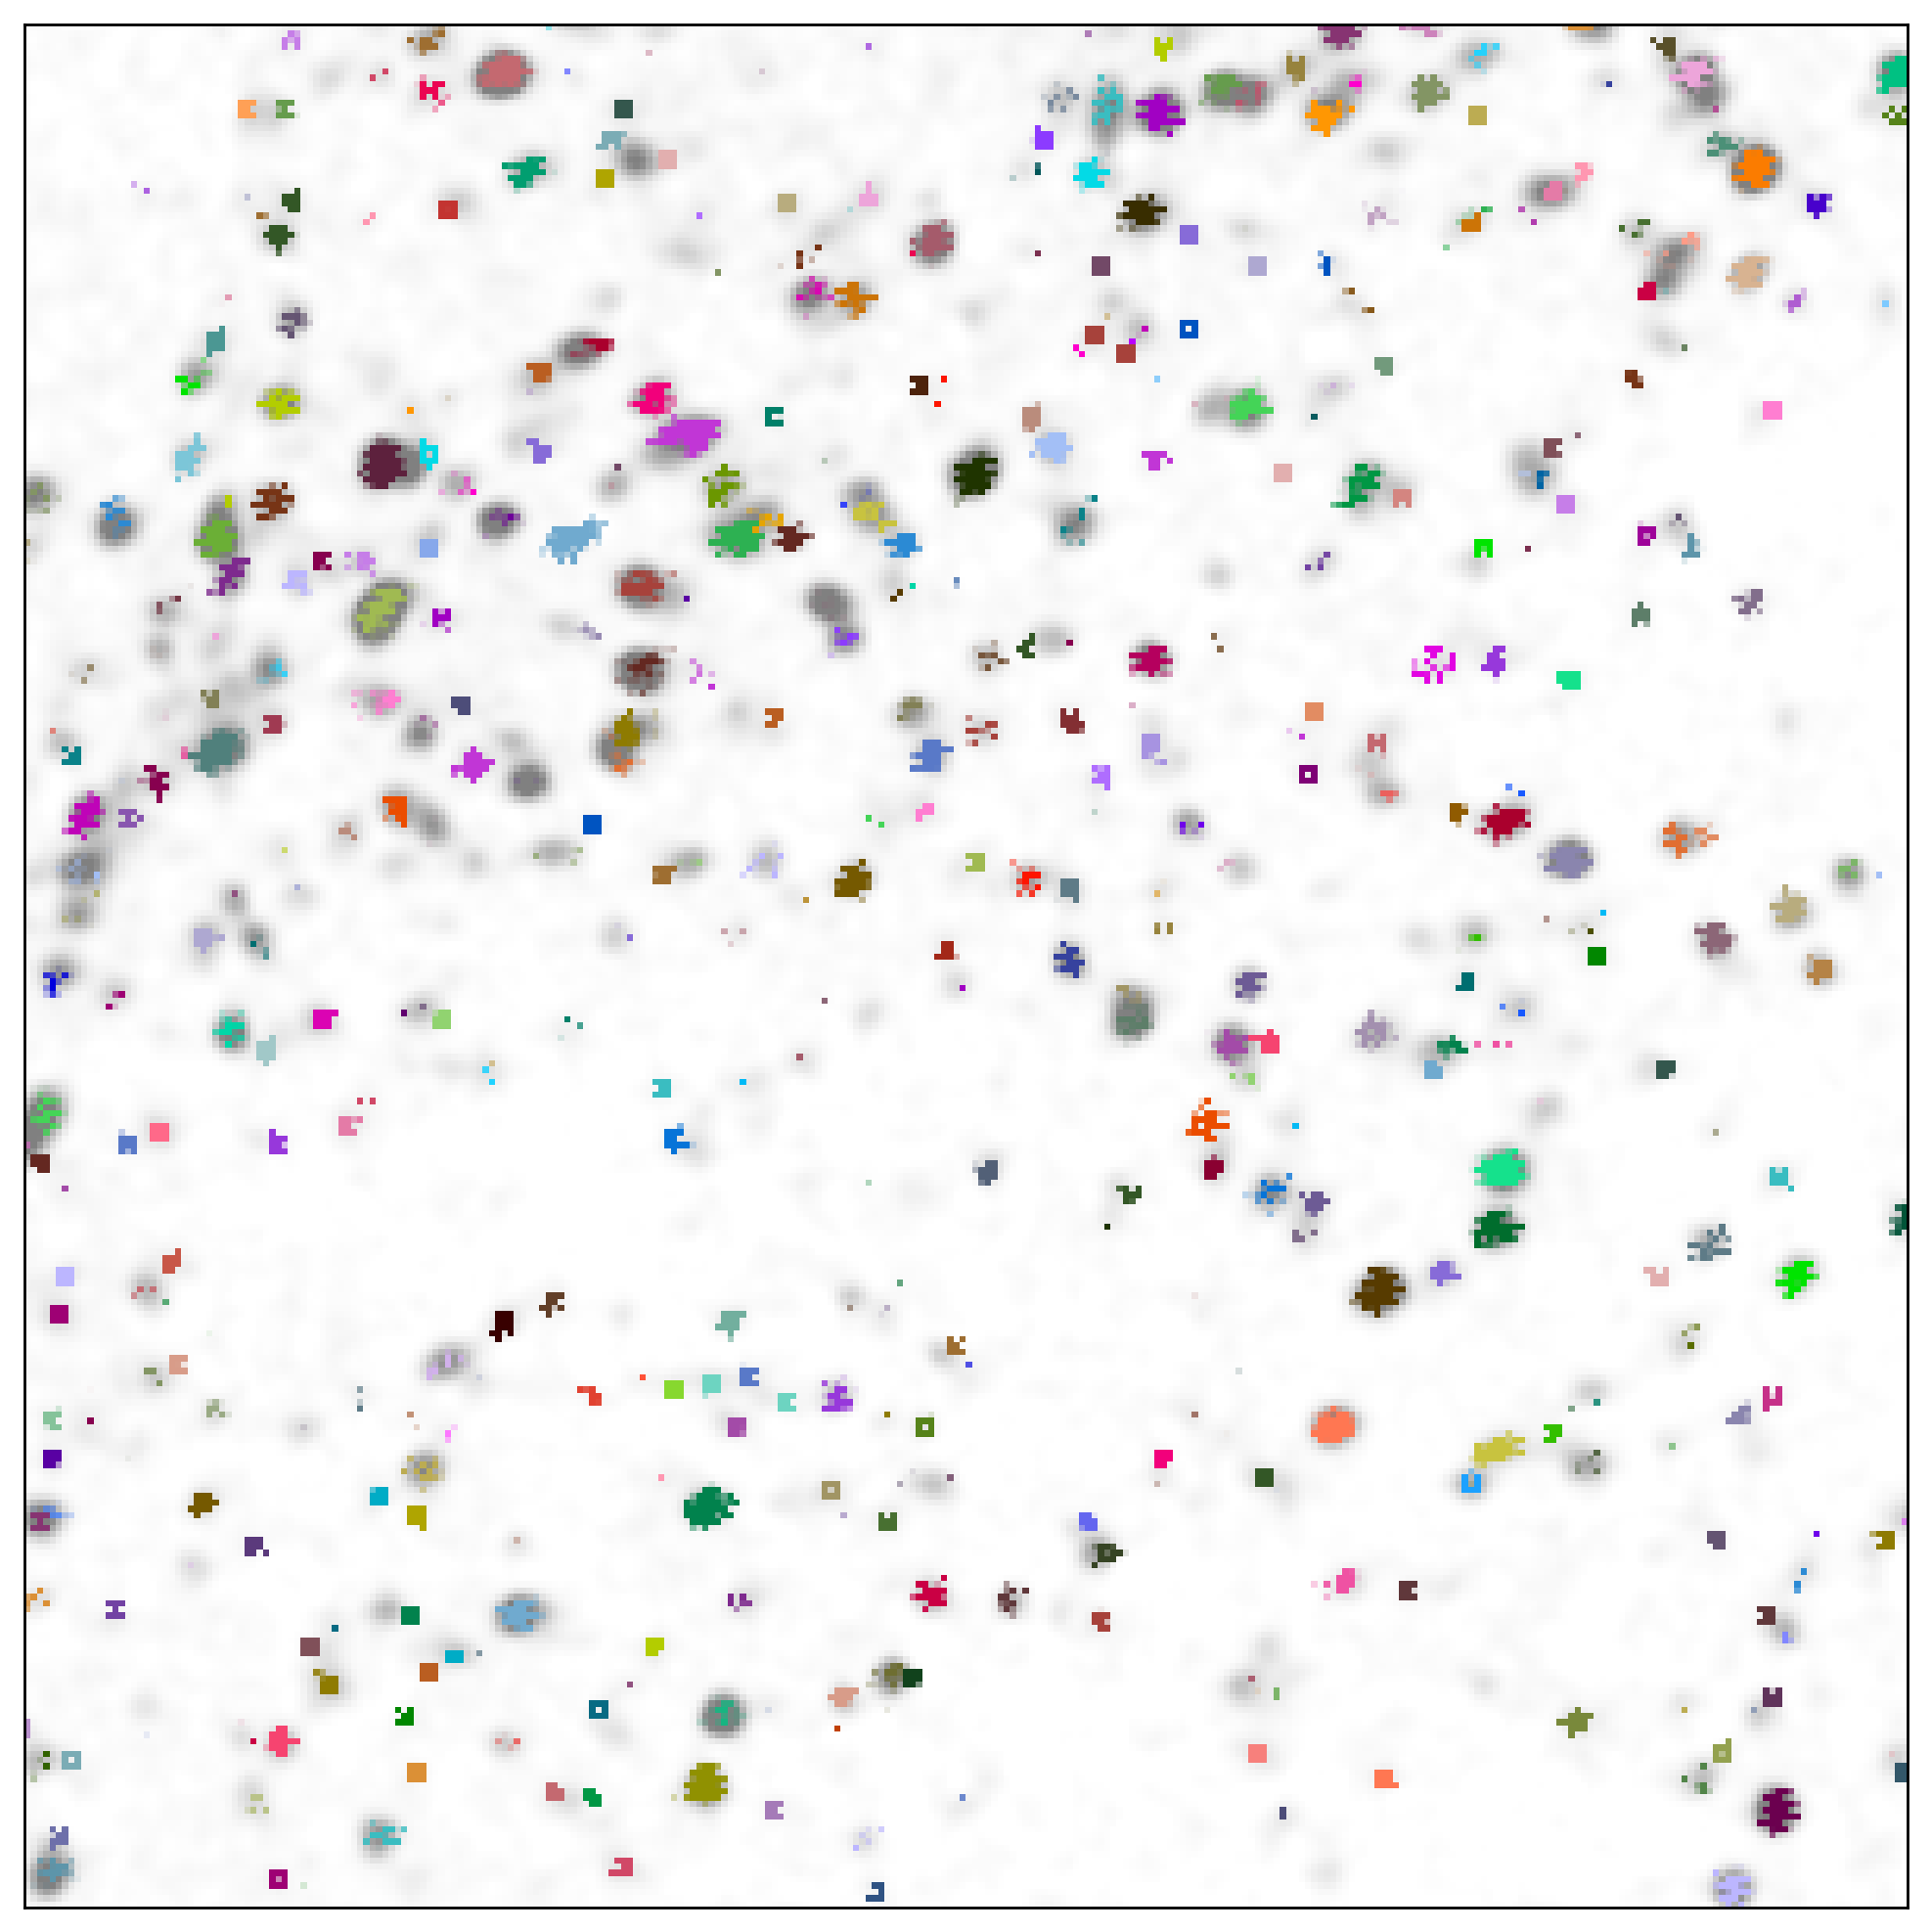

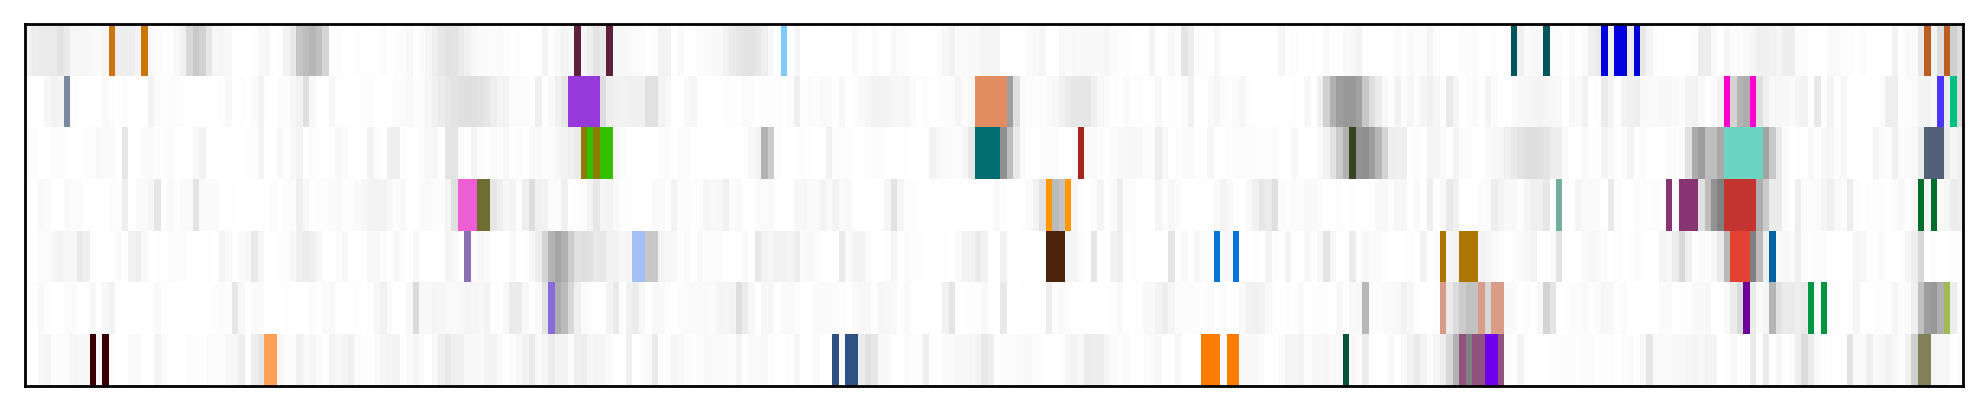

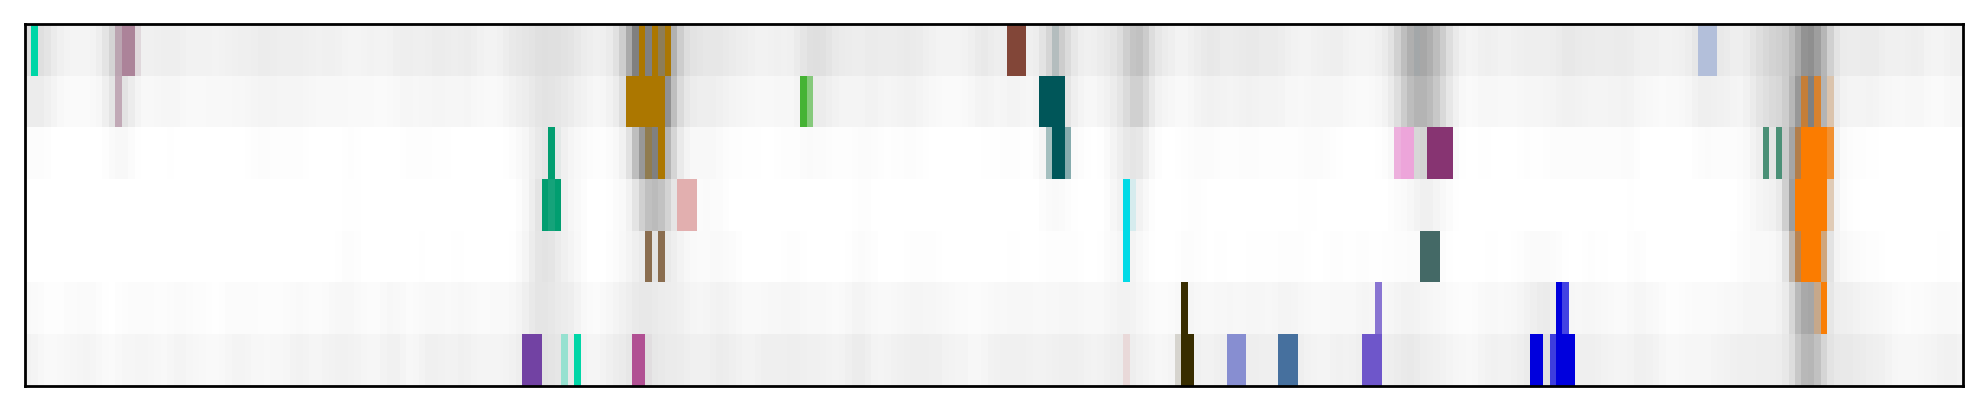

In [10]:
cell_id_vol_s2p, rgb_vol_s2p = ui.make_label_vols(stats_3d, (7,1000,800), lam_max=0.05, cmap='cet_glasbey_dark',
                                         iscell = filt)


cell_id_vol_s3d, rgb_vol_s3d = ui.make_label_vols(seg['stats'], corr_map_s3d.shape, lam_max=0.05, cmap='cet_glasbey_dark',
                                         iscell = n.tile(peaks > 0.020,2).reshape(len(peaks),2))

fsize = (10,10)
dpi = 250
ddx = 0
dx2p = 1
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
zidx = 3
plot.show_tif(vmap_3d_s2p[zidx,290:590, 312:612], cbar=False, cmap='Greys',ax=ax, alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s2p[zidx,290:590, 312:612],ax=ax)
plt.savefig(fdir / "2dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(20)
# ax.axhline(12)
f,ax = plt.subplots(figsize=fsize,dpi=dpi)
plot.show_tif(corr_map_s3d[3,290:590,320:620], cbar=False, cmap='Greys',ax=ax, alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s3d[3,290:590,320:620],ax=ax)
plt.savefig(fdir / "3dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(21)


f,ax = plt.subplots(figsize=fsize, dpi=dpi)w
plot.show_tif(vmap_3d_s2p[:, 309 + dx2p + ddx, 312:612], cbar=False, cmap='Greys',ax=ax, px_py = (1,8), alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s2p[:,309 + dx2p + ddx, 312:612],ax=ax, px_py = (1,8))
plt.savefig(fdir / "2dseg-xz.svg", bbox_inches='tight',pad_inches=0)



f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(corr_map_s3d[:, 311 + ddx, 320:620], cbar=False, cmap='Greys',ax=ax, px_py = (1,8), alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s3d[:,311 + ddx, 320:620],ax=ax, px_py = (1,8))
plt.savefig(fdir / "3dseg-xz.svg", bbox_inches='tight',pad_inches=0)

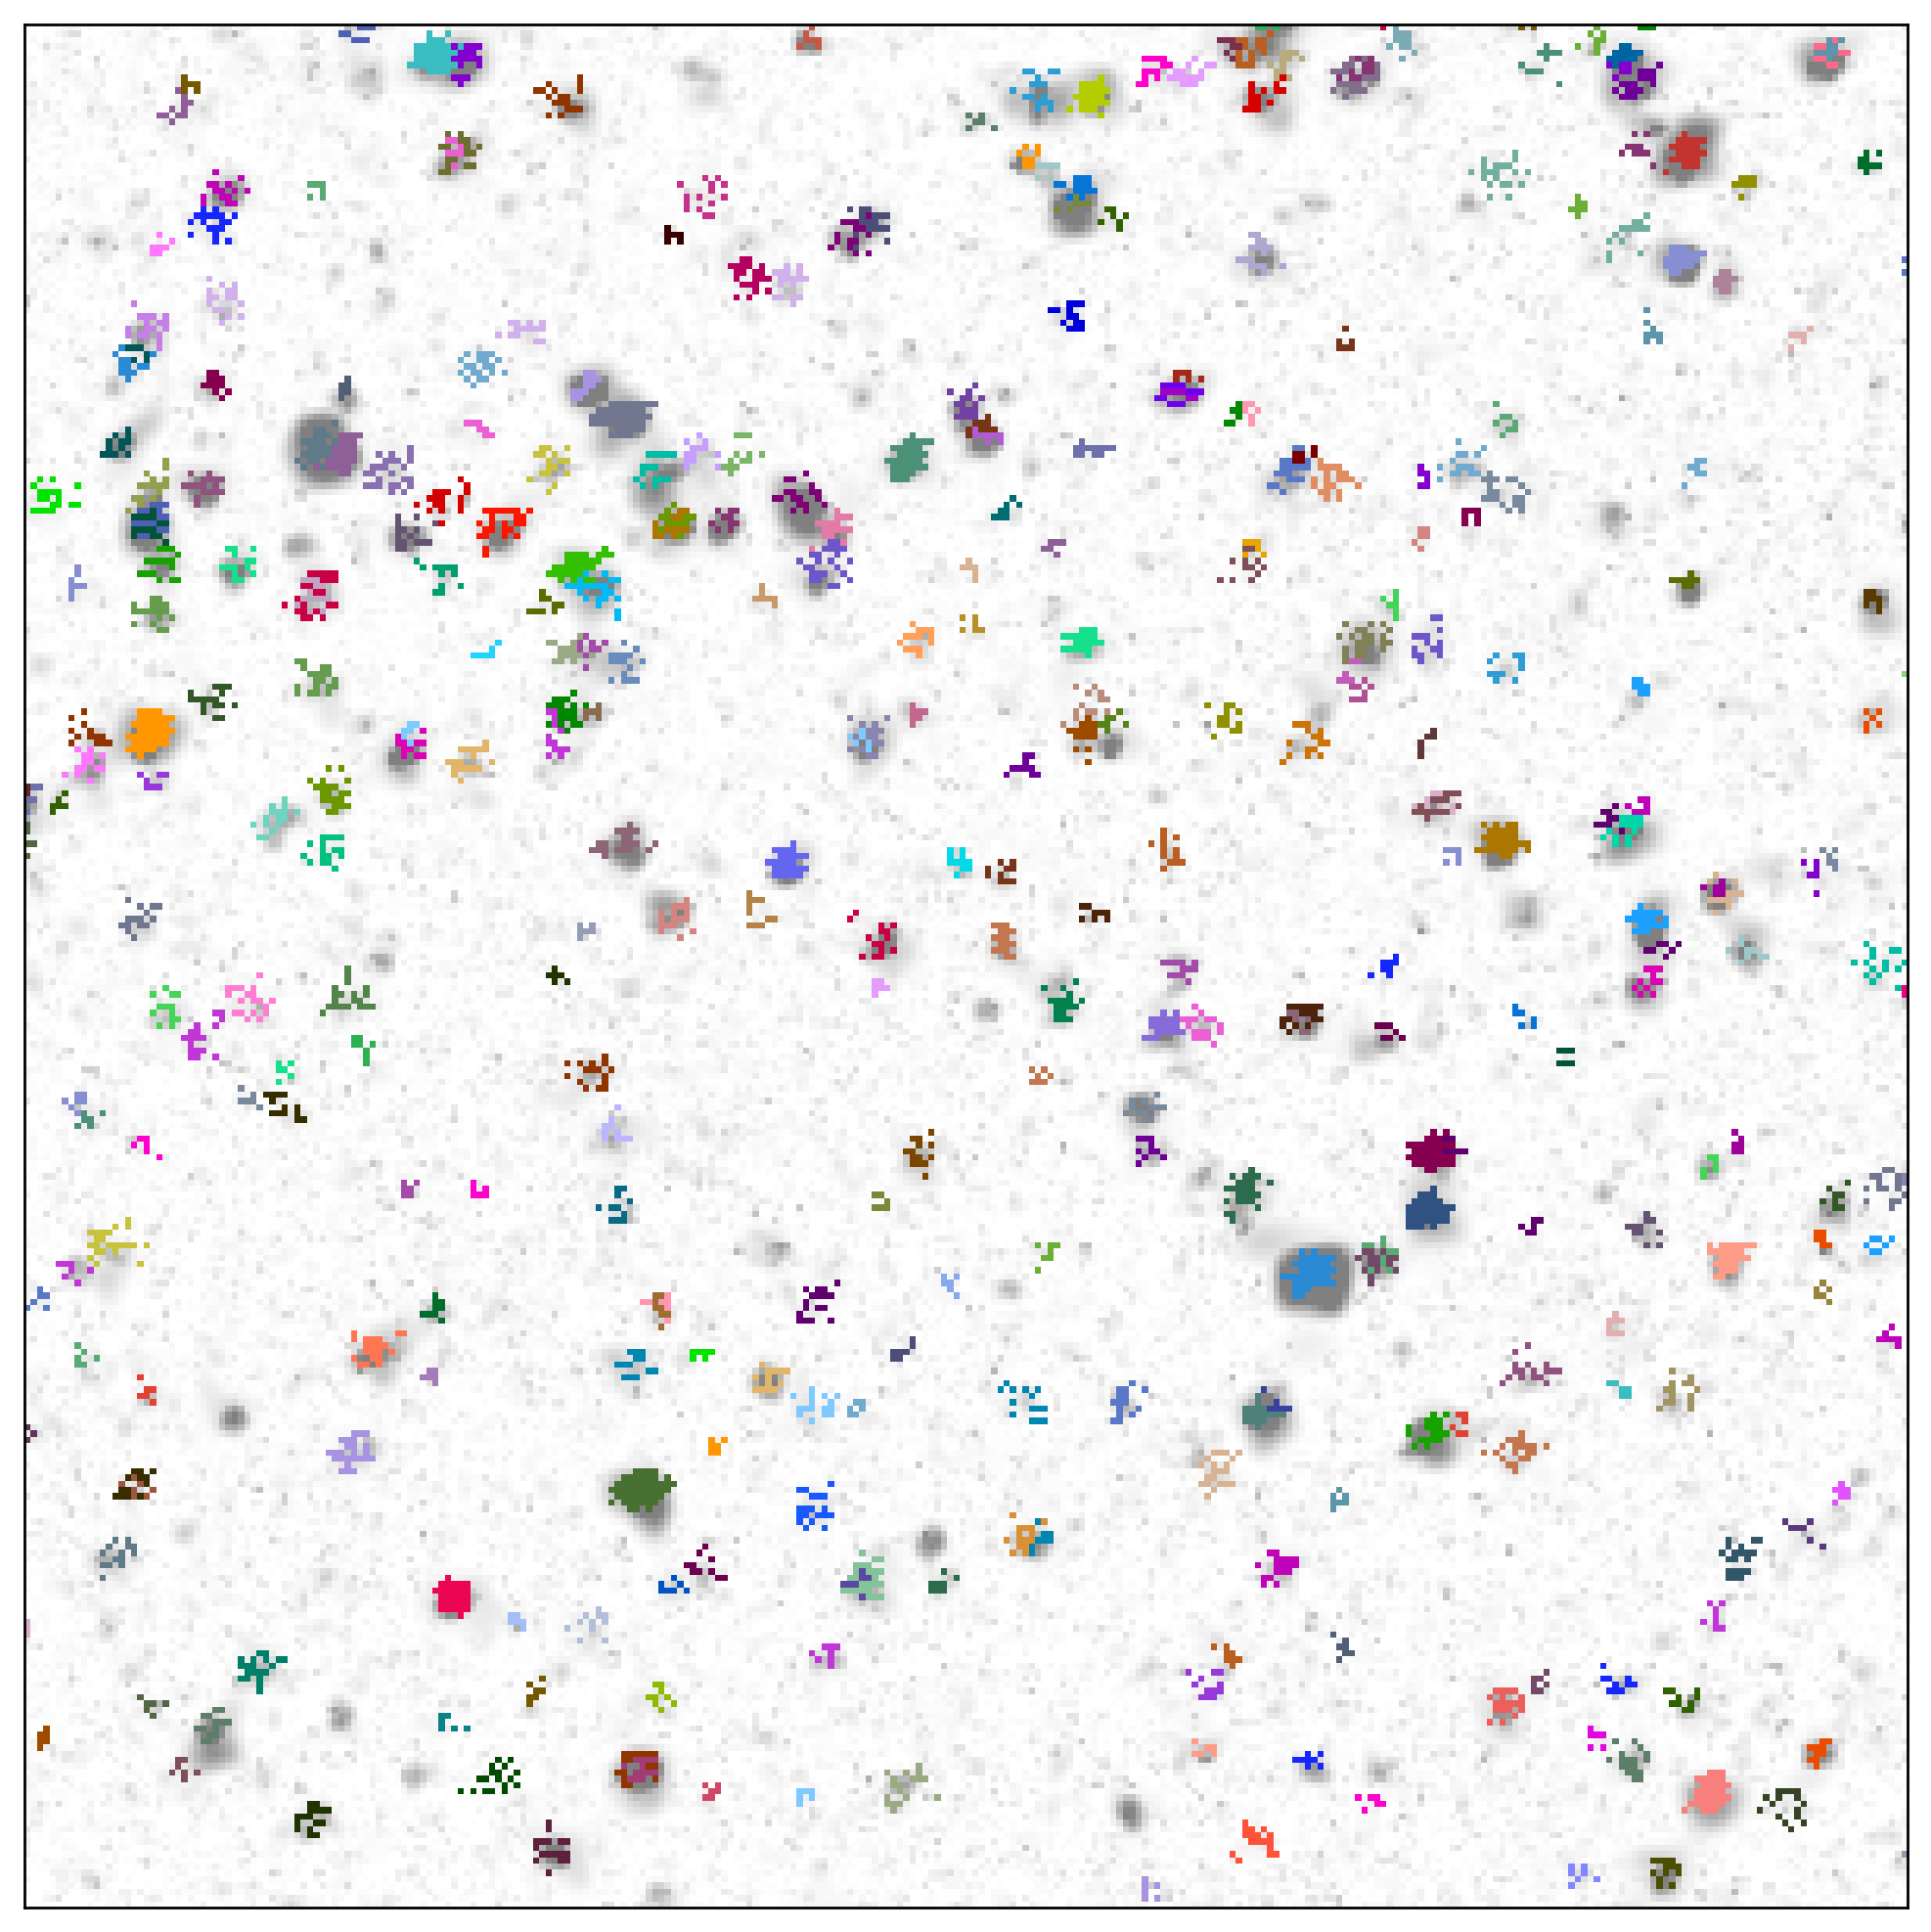

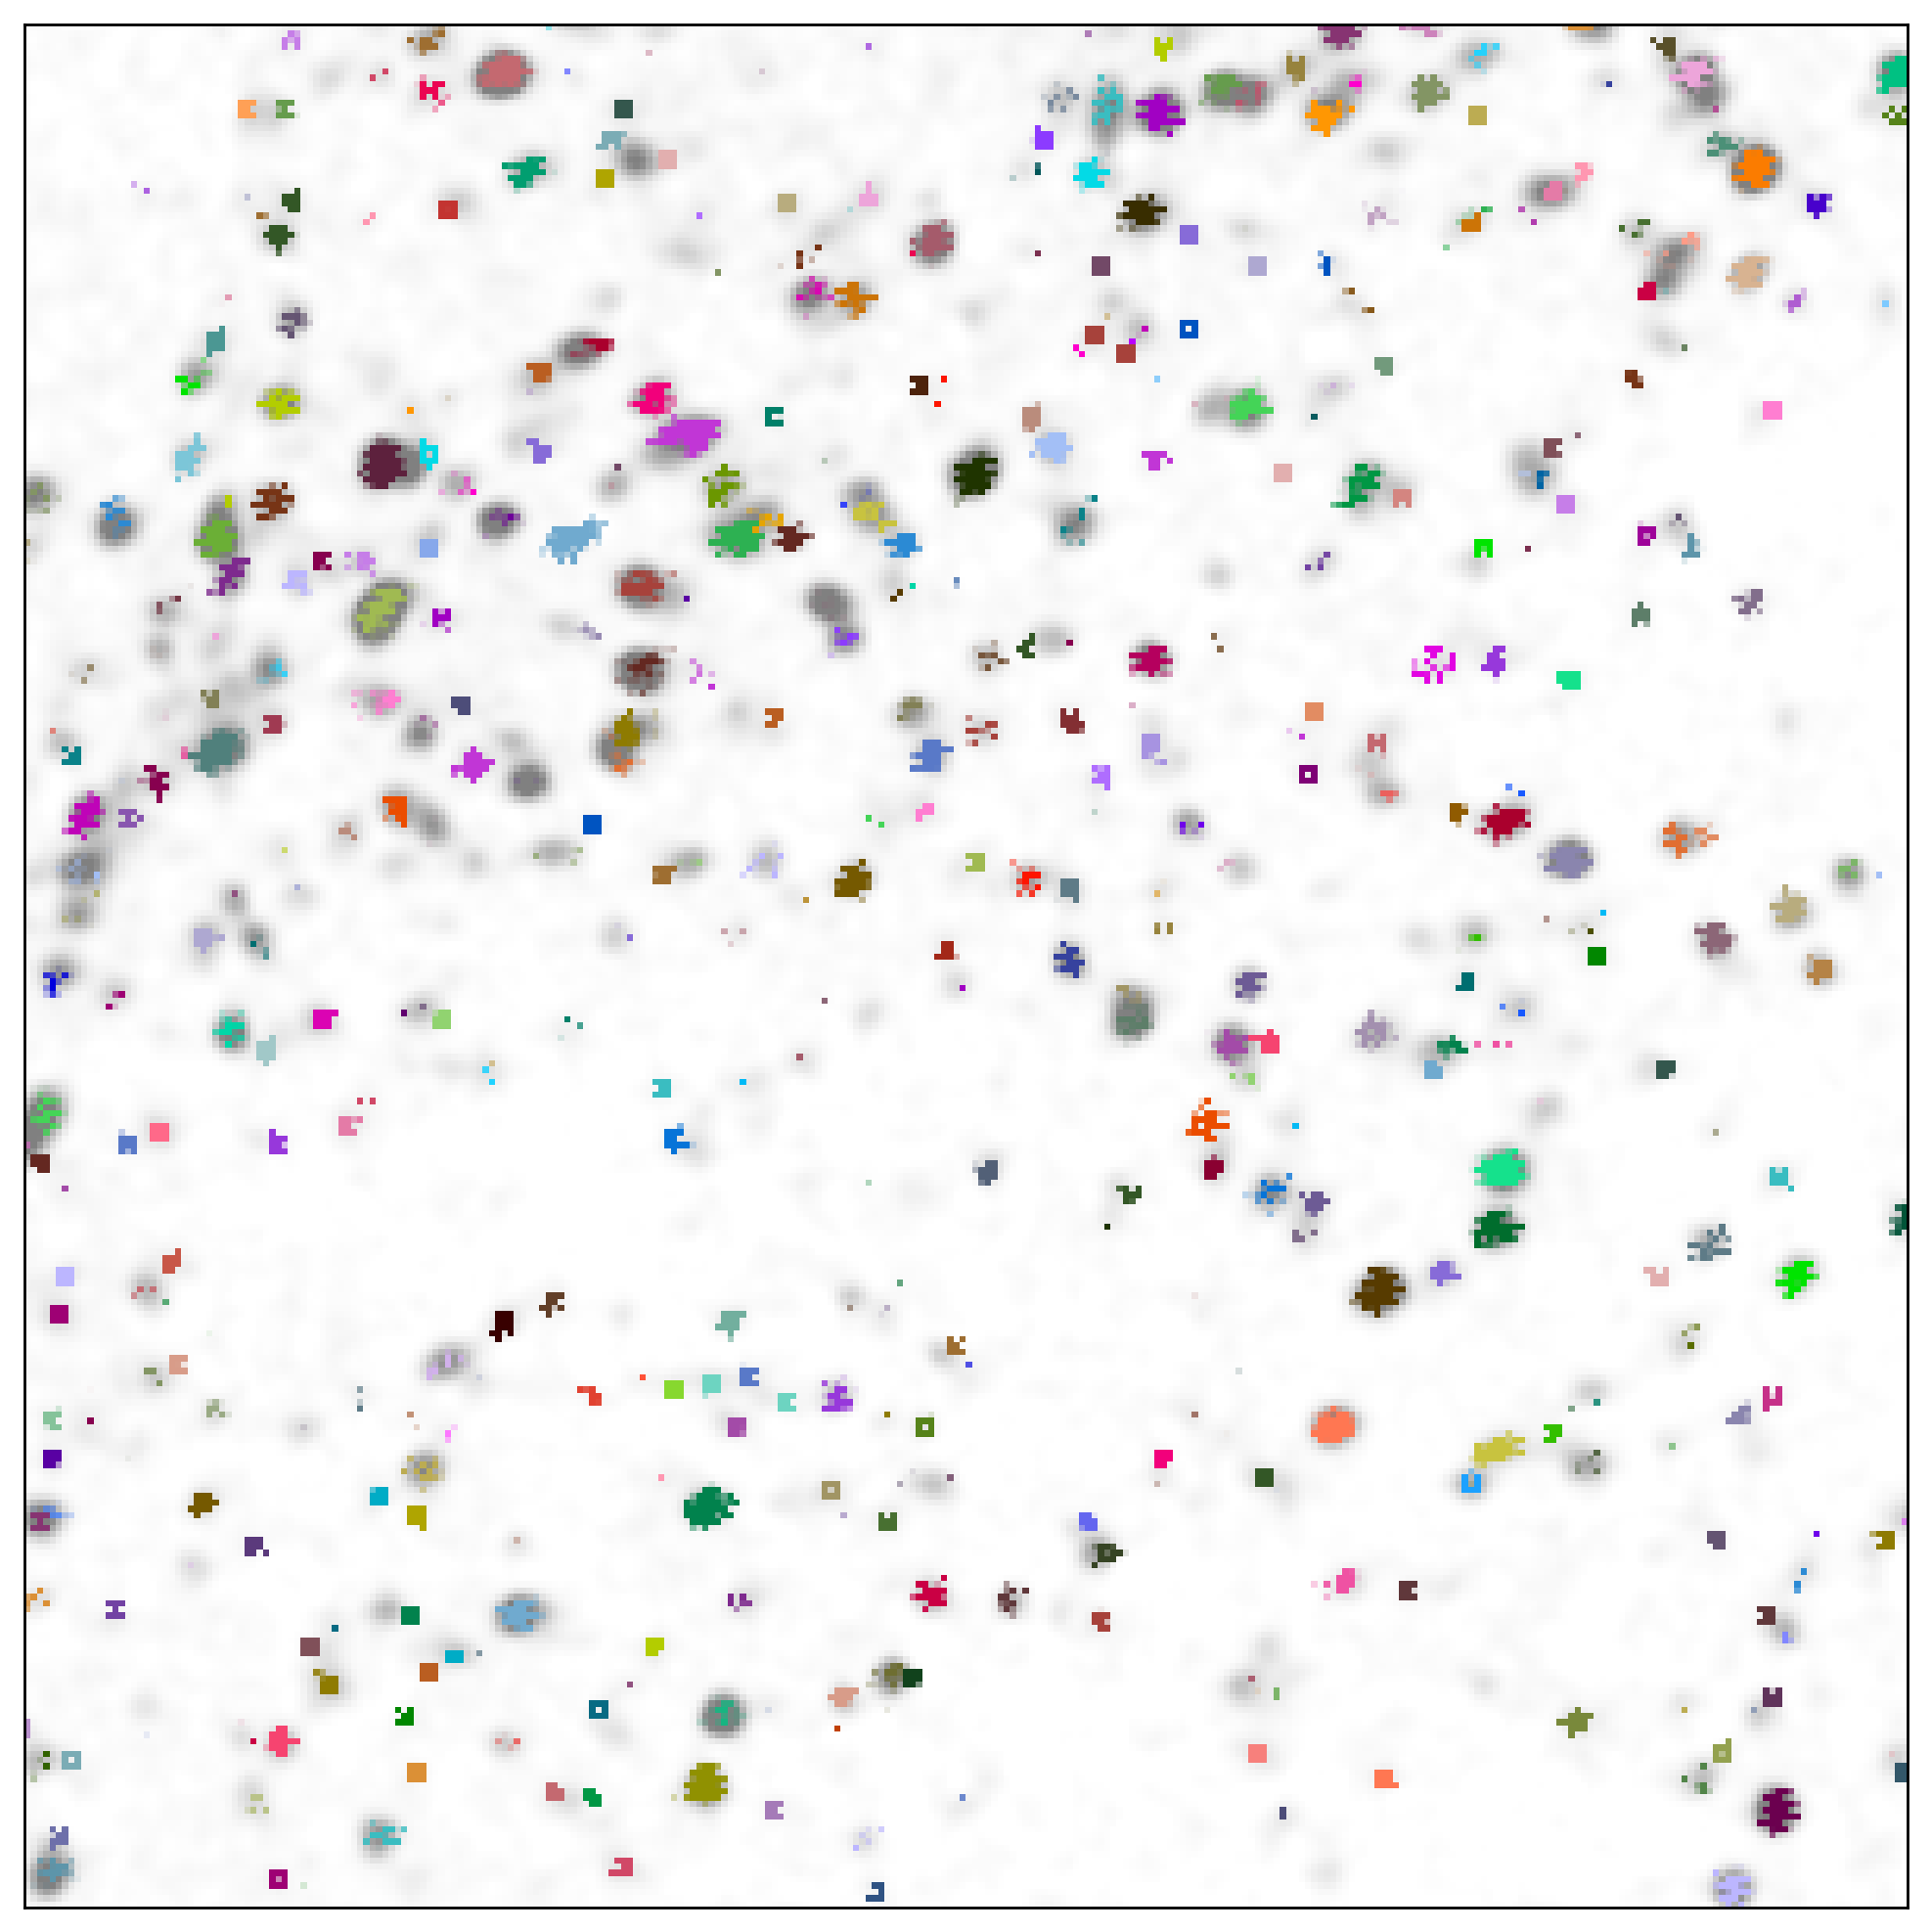

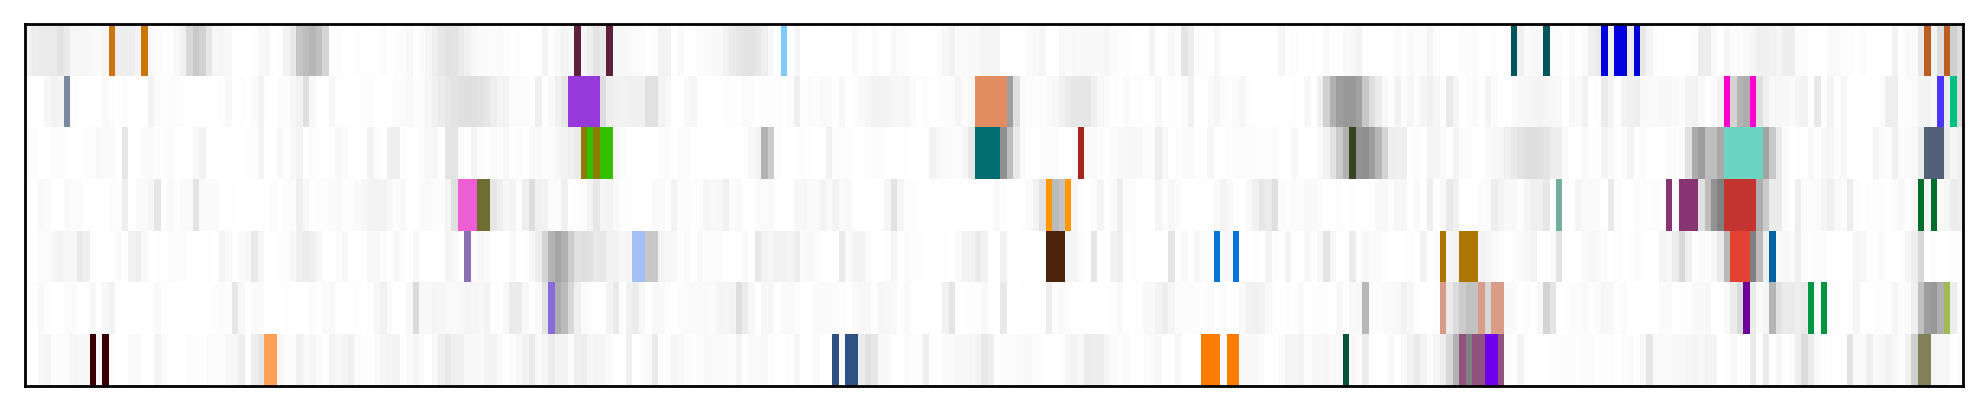

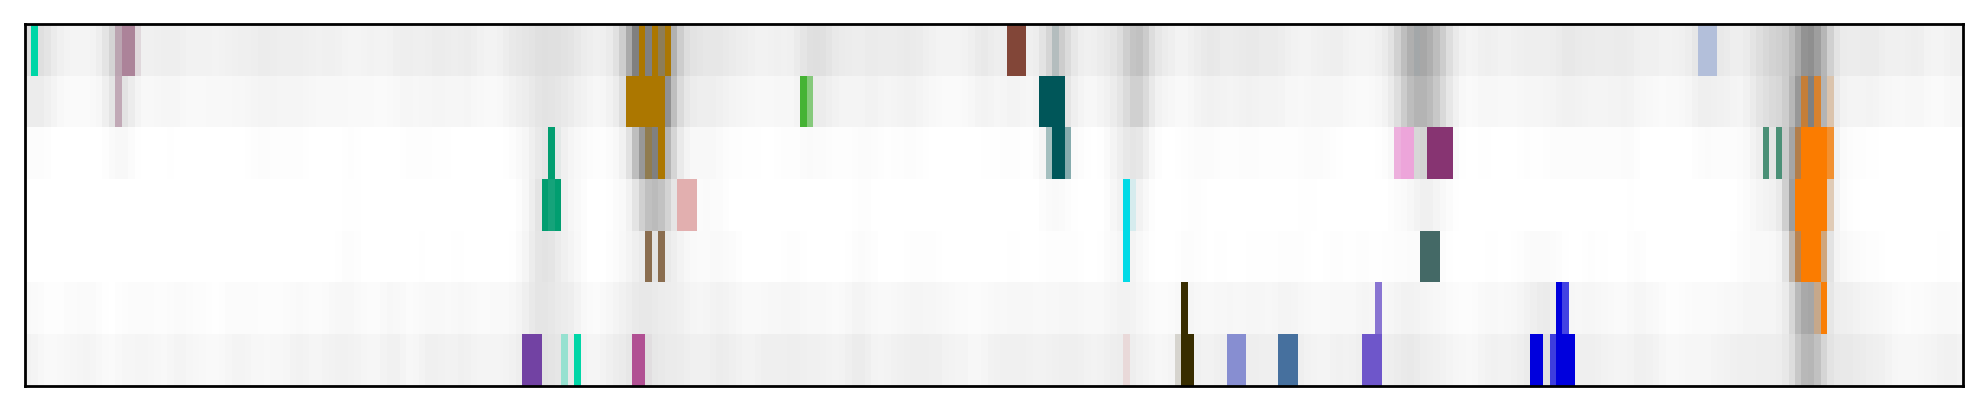

In [12]:
cell_id_vol_s2p, rgb_vol_s2p = ui.make_label_vols(stats_3d, (7,1000,800), lam_max=0.05, cmap='cet_glasbey_dark',
                                         iscell = filt)


cell_id_vol_s3d, rgb_vol_s3d = ui.make_label_vols(seg['stats'], corr_map_s3d.shape, lam_max=0.05, cmap='cet_glasbey_dark',
                                         iscell = n.tile(peaks > 0.020,2).reshape(len(peaks),2))

fsize = (10,10)
dpi = 250
ddx = 0
dx2p = 1
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
zidx = 3
plot.show_tif(vmap_3d_s2p[zidx,290:590, 312:612], cbar=False, cmap='Greys',ax=ax, alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s2p[zidx,290:590, 312:612],ax=ax)
plt.savefig(fdir / "2dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(20)
# ax.axhline(12)
f,ax = plt.subplots(figsize=fsize,dpi=dpi)
plot.show_tif(corr_map_s3d[3,290:590,320:620], cbar=False, cmap='Greys',ax=ax, alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s3d[3,290:590,320:620],ax=ax)
plt.savefig(fdir / "3dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(21)


f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(vmap_3d_s2p[:, 309 + dx2p + ddx, 312:612], cbar=False, cmap='Greys',ax=ax, px_py = (1,8), alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s2p[:,309 + dx2p + ddx, 312:612],ax=ax, px_py = (1,8))
plt.savefig(fdir / "2dseg-xz.svg", bbox_inches='tight',pad_inches=0)



f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(corr_map_s3d[:, 311 + ddx, 320:620], cbar=False, cmap='Greys',ax=ax, px_py = (1,8), alpha=0.5, vminmax_percentile=(20,99))
plot.show_tif(rgb_vol_s3d[:,311 + ddx, 320:620],ax=ax, px_py = (1,8))
plt.savefig(fdir / "3dseg-xz.svg", bbox_inches='tight',pad_inches=0)

In [13]:
putative_merge = ( 6447, 10111 ,15034,20201 ,26561)
putative_merge2 = (466, 5081, 11890 )

In [14]:
Fs.shape

(34994, 2000)

In [15]:
iscell_s2p = filt

In [16]:
fcorr_full = n.corrcoef(Fs[iscell_s2p])
scorr_full = n.corrcoef(spks[iscell_s2p])

In [17]:
fcorr_flat = fcorr_full[n.tril_indices_from(fcorr_full,-1)]
scorr_flat = scorr_full[n.tril_indices_from(fcorr_full,-1)]

In [18]:
fcorr_flat.shape

(130677861,)

In [19]:
corrs1 = []
scorrs1 = []
for i in range(len(putative_merge)):
    for j in range(i):
        corrs1.append(n.corrcoef(Fs[putative_merge[i]],Fs[putative_merge[j]])[0,1])
        scorrs1.append(n.corrcoef(spks[putative_merge[i]],spks[putative_merge[j]])[0,1])

corrs2 = []
scorrs2 = []
for i in range(len(putative_merge2)):
    for j in range(i):
        corrs2.append(n.corrcoef(Fs[putative_merge2[i]],Fs[putative_merge2[j]])[0,1])
        scorrs2.append(n.corrcoef(spks[putative_merge2[i]],spks[putative_merge2[j]])[0,1])

In [20]:
fcorr_hist = n.histogram(fcorr_flat, bins=n.linspace(-1,1,101), density=True)
scorr_hist = n.histogram(scorr_flat, bins=n.linspace(-1,1,101), density=True)

In [21]:
bins = (fcorr_hist[1][1:] + fcorr_hist[1][:-1])/2

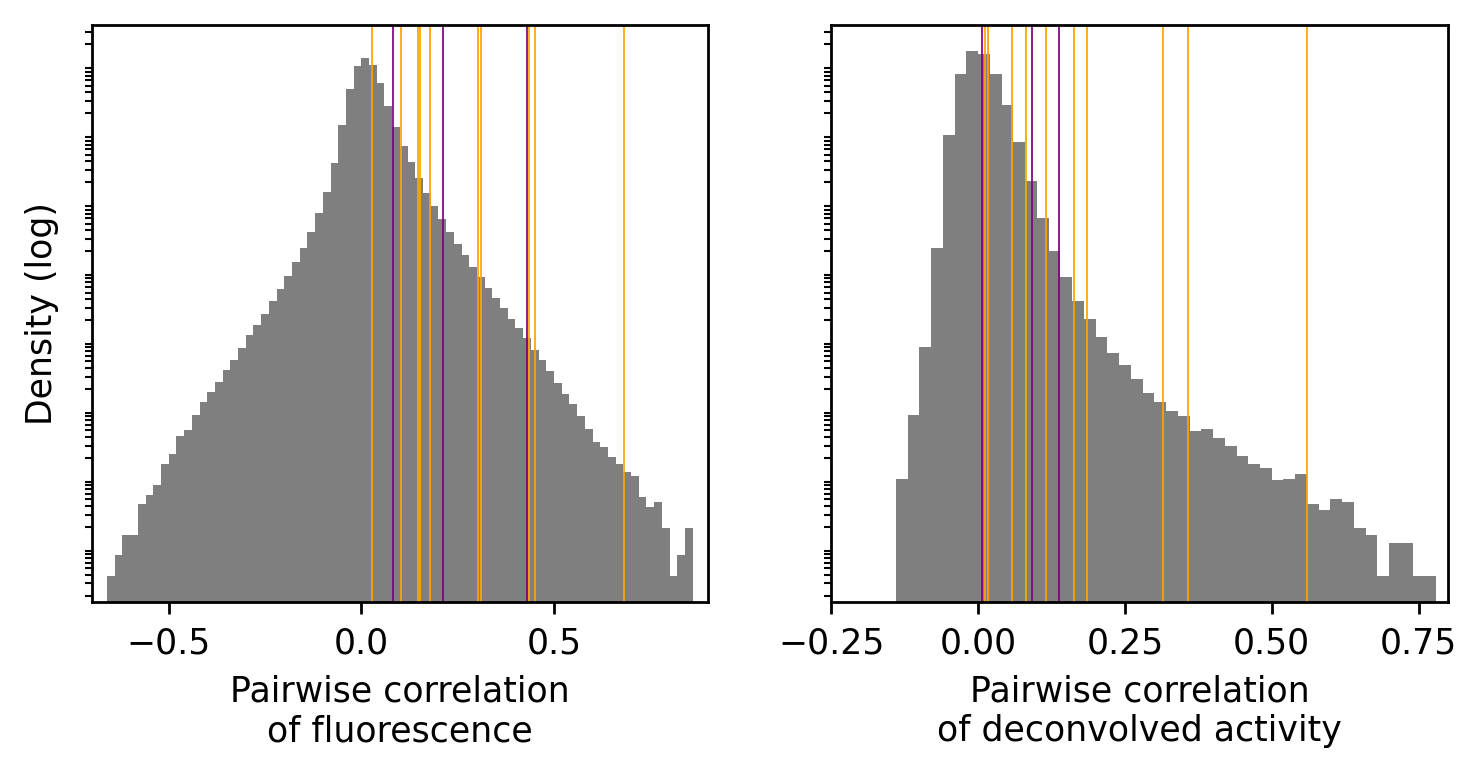

In [22]:
f,axs = plt.subplots(1,2, figsize=(7,3), dpi=250, sharey=True)
ls = None#(0,(4,2))
lw = 0.5
la = 1.0

ax = axs[0]
ax.set_yscale('log')
ax.bar(bins, fcorr_hist[0], width=n.diff(bins).mean(), color='k', alpha=0.5)
for cx in corrs1:
    ax.axvline(cx, color='orange', lw=lw, linestyle=ls, alpha=la)
for cx in corrs2:
    ax.axvline(cx, color='purple', lw=lw, linestyle=ls, alpha=la)
# ax.set_ylim(1e-6, 30)
ax.set_xlim(-0.7, 0.9)
ax.set_xlabel("Pairwise correlation\nof fluorescence")
ax.set_ylabel("Density (log)")
ax.set_yticks([])



ax = axs[1]
# ax.set_yscale('log')
ax.bar(bins, scorr_hist[0], width=n.diff(bins).mean(), color='k', alpha=0.5)
for cx in scorrs1:
    ax.axvline(cx, color='orange', lw=lw, linestyle=ls, alpha=la)
for cx in scorrs2:
    ax.axvline(cx, color='purple', lw=lw, linestyle=ls, alpha=la)
ax.set_xlim(-0.25, 0.8)
# ax.set_ylim(1e-6, 30)
ax.set_xlabel("Pairwise correlation\nof deconvolved activity")
plt.savefig(fdir / "paircorr-histograms.svg", bbox_inches='tight',pad_inches=0)


In [ ]:
for s in stats_3d:
    s['lam_old'] = s['lam'].copy()
    s['lam'] /= n.sqrt((s['lam']**2).sum())

In [ ]:
rgb_vol_s2p[zidx,288:588, 302:602].shape

In [ ]:
# iscell = n.tile(peaks > 0.010,2).reshape(len(peaks),2))

fsize = (10,10)
dpi = 250
ddx = 0
dx2p = 1
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
zidx = 3

lmax = 0.5
gamma = 0.5
cell_id_vol_s2p, rgb_vol_s2p = ui.make_label_vols(stats_3d, (7,1000,800), lam_max=lmax, cmap='cet_glasbey_dark',
                                         iscell = filt)


cell_id_vol_s3d, rgb_vol_s3d = ui.make_label_vols(seg['stats'], corr_map_s3d.shape, lam_max=lmax, cmap='cet_glasbey_dark',
                                                 )## plot.show_tif(vmap_3d_s2p[zidx,290:590, 312:612], cbar=False, cmap='Greys',ax=ax, alpha=0.5, vminmax_percentile=(20,99))
cells2d = rgb_vol_s2p[:,288:588, 302:602].copy()
cells3d = rgb_vol_s3d[:,290:590,320:620].copy()

f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(cells3d[zidx]**gamma,ax=ax)
# plt.savefig(fdir / "3dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(21)
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(cells2d[zidx]**gamma,ax=ax)



In [ ]:
# iscell = n.tile(peaks > 0.010,2).reshape(len(peaks),2))

fsize = (10,10)
dpi = 250
ddx = 0
dx2p = 1
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
zidx = 3

lmax = 0.5
gamma = 0.5
cell_id_vol_s2p, rgb_vol_s2p = ui.make_label_vols(stats_3d, (7,1000,800), lam_max=lmax, cmap='cet_glasbey_dark',
                                         iscell = filt)


cell_id_vol_s3d, rgb_vol_s3d = ui.make_label_vols(seg['stats'], corr_map_s3d.shape, lam_max=lmax, cmap='cet_glasbey_dark',
                                                 )## plot.show_tif(vmap_3d_s2p[zidx,290:590, 312:612], cbar=False, cmap='Greys',ax=ax, alpha=0.5, vminmax_percentile=(20,99))
cells2d = rgb_vol_s2p[:,288:588, 302:602].copy()
cells3d = rgb_vol_s3d[:,290:590,320:620].copy()


# plot.show_tif(corr_map_s3d[3,290:590,320:620], cbar=False, cmap='Greys',ax=ax, alpha=0.5, vminmax_percentile=(20,99))

# f,ax = plt.subplots(figsize=fsize, dpi=dpi)
# # plot.show_tif(vmap_3d_s2p[:, 309 + dx2p + ddx, 312:612], cbar=False, cmap='Greys',ax=ax, px_py = (1,8), alpha=0.5, vminmax_percentile=(20,99))
# plot.show_tif(rgb_vol_s2p[:,309 + dx2p + ddx, 312:612],ax=ax, px_py = (1,8))
# plot.show_tif(cells2d[:, ])
# plt.savefig(fdir / "2dseg-xz.svg", bbox_inches='tight',pad_inches=0)
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(cells3d[9]**gamma,ax=ax)
# plt.savefig(fdir / "3dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(21)
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(cells2d[zidx]**gamma,ax=ax)
# plt.savefig(fdir / "2dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(20)
# ax.axhline(12)
# f,ax = plt.subplots(figsize=fsize,dpi=dpi)


In [ ]:
plot.show_tif(cells3d[zidx]**gamma,ax=ax)
plt.savefig(fdir / "3dseg-xy.svg", bbox_inches='tight',pad_inches=0)
# ax.axhline(21)

In [ ]:
cells3d.shape

In [ ]:
cells3d.shape

IndexError: index 10 is out of bounds for axis 2 with size 4

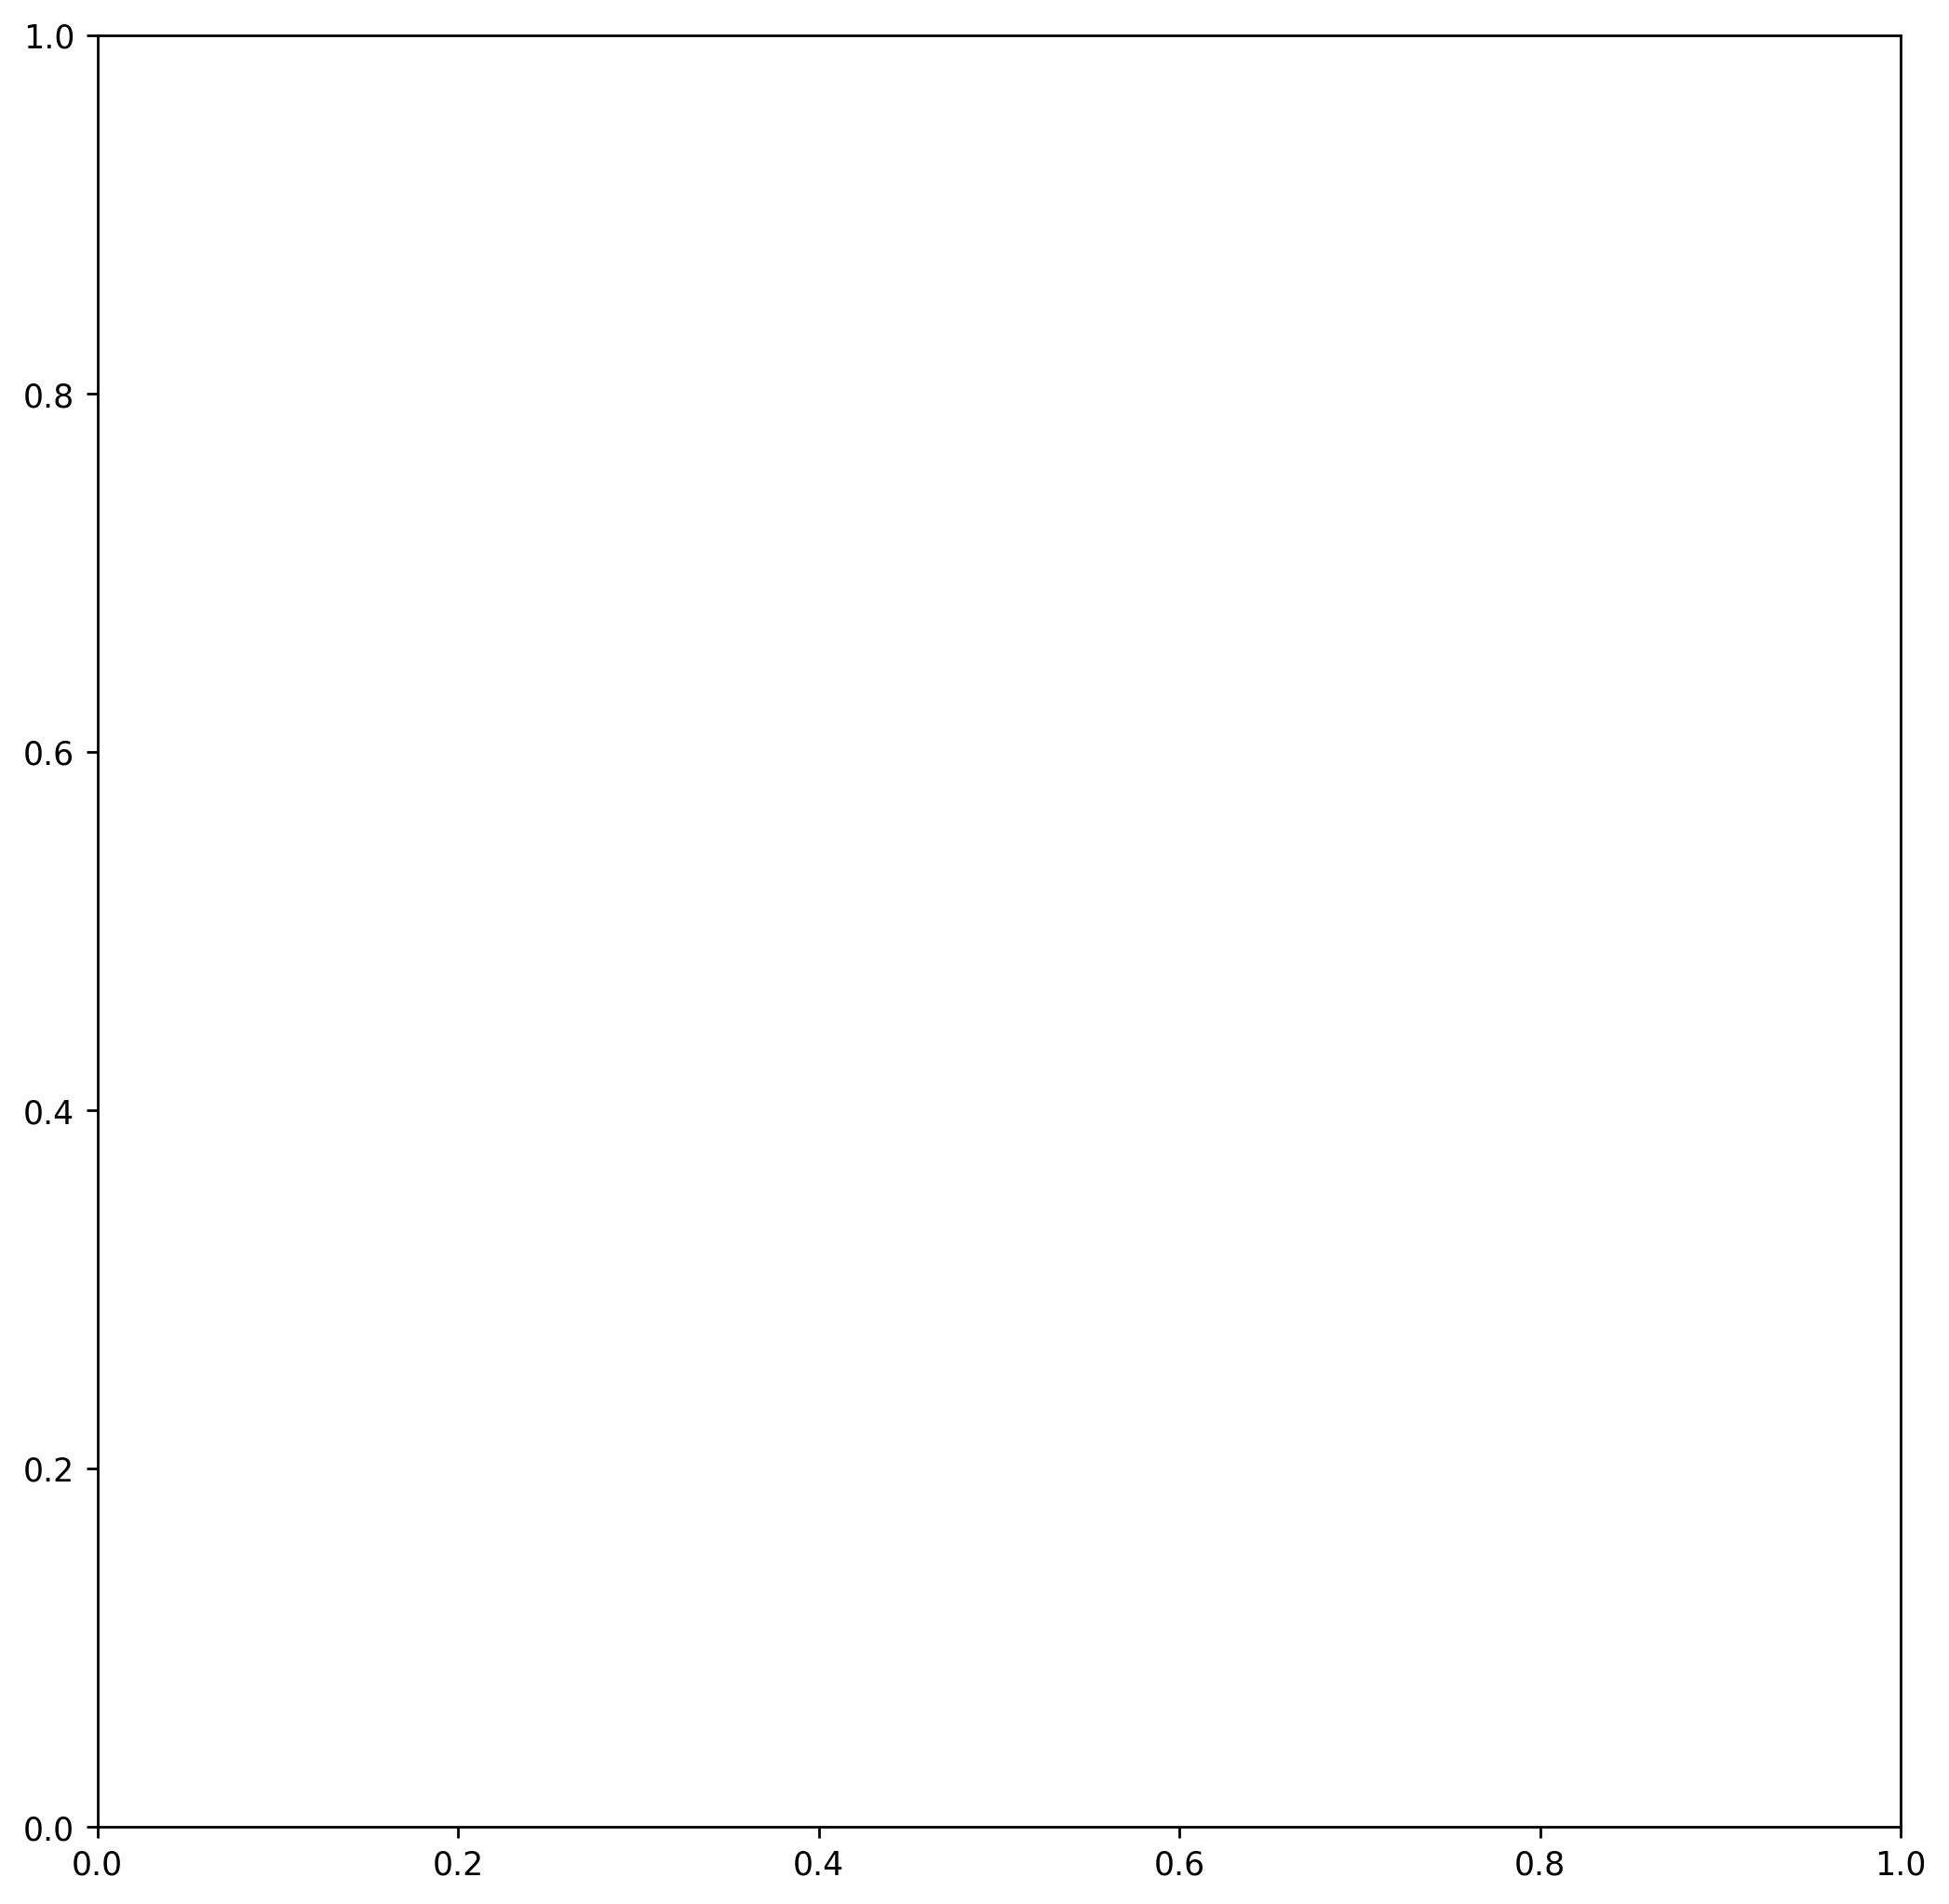

In [49]:
f,ax = plt.subplots(figsize=fsize, dpi=dpi)
plot.show_tif(cells3d[:,:,10]**gamma,ax=ax, px_py = (1,8))
# plt.savefig(fdir / "3dseg-xz.svg", bbox_inches='tight',pad_inches=0)